# 2021 KT빅데이터 플랫폼 경진대회

# 목차
## 서론
 * 현재 한국 코로나 발생현황
## 본론
### 1. 코로나-19로 인한 수도권 배달 산업 현황
* 배달 건수 현황
* 업종 별 배달 건수 현황
* 배달전문업체의 창업 현황
* 생활폐기물 발생량 현황
* 재활용폐기물 발생량 현황

### 2. 코로나-19로 인한 수도권 배달량과 생활폐기물 및 재활용 폐기물 발생량의 상관관계

* 상관관계 분석

## 결론

## 제안 기대효과

# 서론
코로나 바이러스의 확산으로 인해 재택근무, 비대면 모임 등이 활성화 되었고, 자연스럽게 배달 이용량 역시 증가하고 있습니다. 

배달량이 증가함에 따라 이때 사용되는 일회용 폐기물 역시 증가하고 있습니다. 저희는 제공받은 코로나 바이러스 데이터, 배달량 데이터에 일회용 폐기물 데이터를 함께 분석하여 상관관계를 보이고, 이를 해결하기 위한 새로운 서비스를 제안하고자 합니다.

관련 뉴스 기사 링크
* “족발 2인분에 15개 일회용품...재활용 가능한 건 없었다” : https://www.hankookilbo.com/News/Read/A2021021213340000980
* "배달음식 시켰는데… 일회용품 폭탄" : http://biz.newdaily.co.kr/site/data/html/2020/09/15/2020091500088.html
* “[MZ세대의 '눈'] 배달 용기 '쓰레기의 민족'으로 역사에 남지 않기를” : http://www.busan.com/view/busan/view.php?code=2021080613513504763

### 사용한 라이브러리 

In [15]:
import scipy.stats as stats
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.pyplot import *

warnings.filterwarnings('ignore')

mpl.rc('font', family='Malgun Gothic')
plt.rc('font', family='Malgun Gothic')
matplotlib.style.use('fivethirtyeight')

In [16]:
from notebook.services.config import ConfigManager

cm = ConfigManager().update('notebook', {'limit_output': 1000000})
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [17]:
def hide_x_label(ax) : # x label을 숨기는 함수
    x_axis = ax.axes.get_xaxis()
    x_label = x_axis.get_label()
    x_label.set_visible(False)
    
def show_height(ax, height_unit, multiply, decimals, font_size = 12) : # bar 그래프의 높이를 표시하는 함수
    for a in ax.patches:
        txt = np.round(a.get_height() * multiply, decimals=decimals) 

        anot = txt.astype('str')
        ax.annotate(anot + height_unit, (a.get_x() +a.get_width()/2, a.get_height() ),
                    ha='center', va='center', xytext=(0, 10),
                    textcoords='offset points', fontsize=font_size)

In [18]:
# 분석 시작일, 종료일
first_epidemic = "2020-02-21" # 한국 첫 유행 시작 날짜
end_date = "2020-05-31" # 마지막 배달 데이터의 날짜

## 현재 한국 코로나 발생 현황

In [19]:
# 코로나 환자 Data Read, 서울 지역만 select
corona = pd.read_csv('./covid_19_dataset/PatientInfo.csv')
is_seoul= corona["province"] == "Seoul"
corona = corona[is_seoul]

# 코로나 정책 Data Read
policy = pd.read_csv('./covid_19_dataset/Policy.csv')

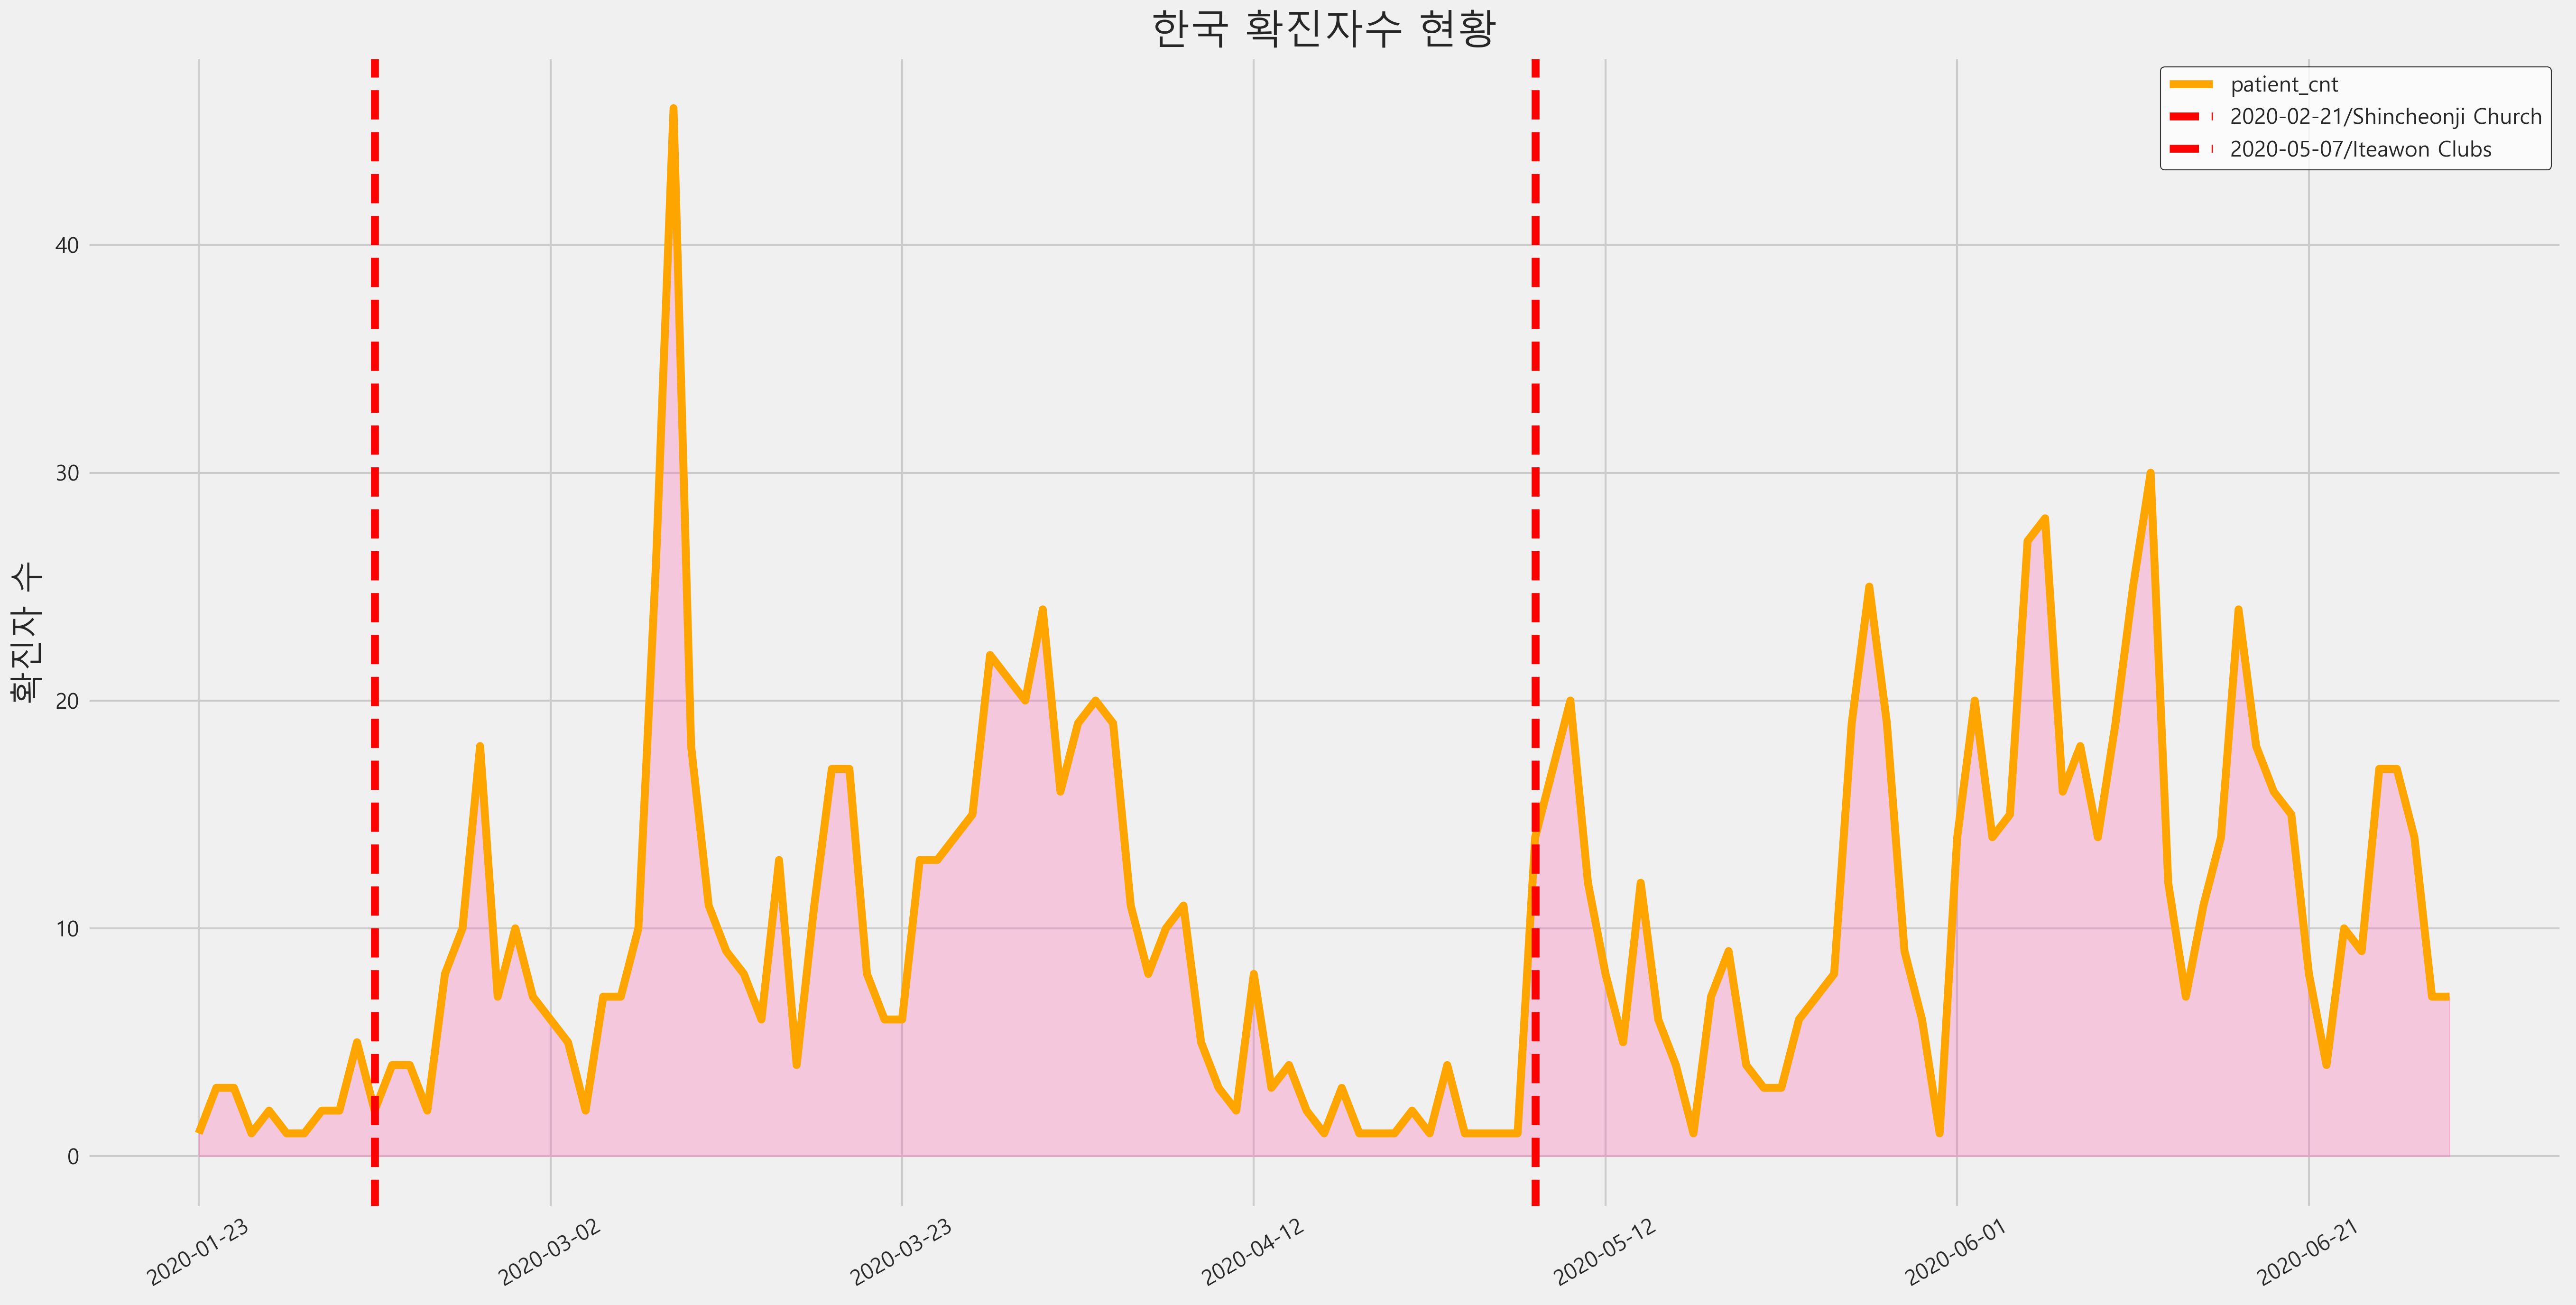

In [20]:
# 서울 지역의 코로나 일일 확진자 수 추이 시각화
confirmed_cnt = corona.groupby('confirmed_date')["patient_id"].count().reset_index(name='patient_cnt')

ax = confirmed_cnt.plot(x = "confirmed_date", y = ["patient_cnt"], figsize = (20,10), 
                        rot = 30, title = "한국 확진자수 현황", color = "orange", ylabel = "확진자 수")

plt.fill_between(confirmed_cnt["confirmed_date"], confirmed_cnt["patient_cnt"], color = 'hotpink', alpha = .3)

plt.axvline(x = '2020-02-21', color = 'red', linestyle = '--', label = '2020-02-21/Shincheonji Church')
plt.axvline(x = '2020-05-08', color = 'red', linestyle = '--', label = '2020-05-07/Iteawon Clubs')

hide_x_label(ax)
plt.legend(facecolor = "white", edgecolor= "black")
plt.show()

2020년 코로나 확진자가 처음 발생하면서 신천지교회에서 코로나 확진자가 발생했을 때와 이태원 클럽에서 코로나 확진자가 발생했을 때를 시점으로 급격하게 증가함을 알 수 있었습니다.

# 본론
## 1. 코로나-19로 인한 수도권 배달 산업 현황
### 1-1. 서울시 배달 건수 현황

In [21]:
# 배달 Data Read
dlvr_call = pd.DataFrame(pd.read_csv("KT_BigDataPlatform_dataset/dlvr_call.csv", encoding = "utf8"))

# 서울특별시의 배달 건만 Select
dlvr_call=dlvr_call[dlvr_call['DLVR_STORE_BRTC_NM'] == '서울특별시']

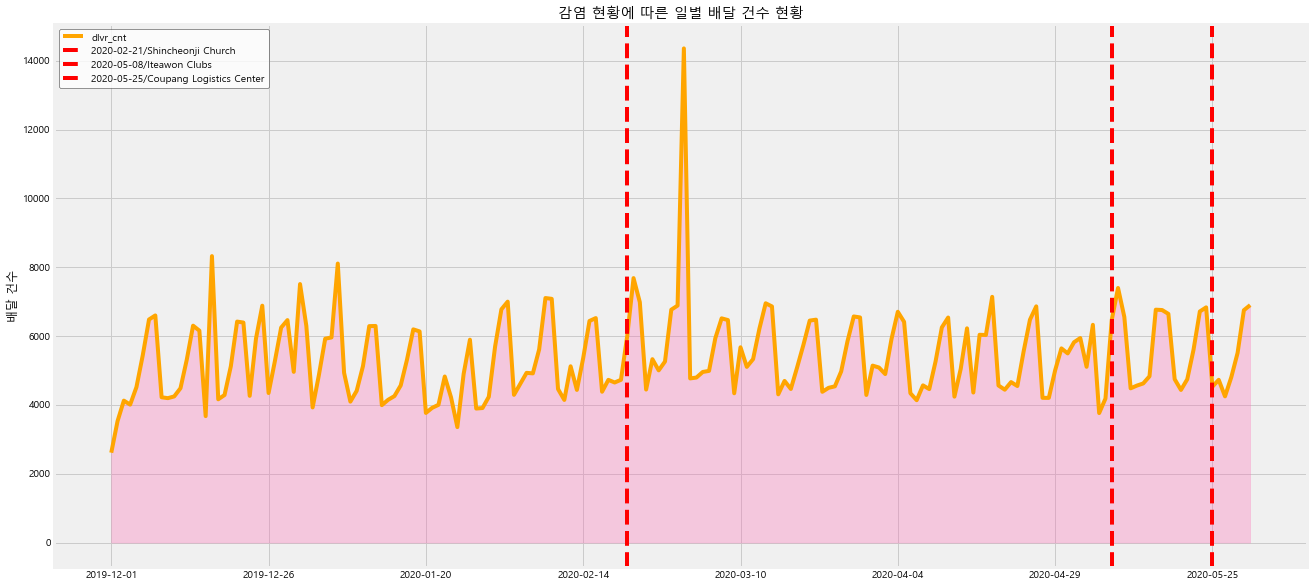

In [8]:
# 배달 완료된 주문만 사용
is_completed = dlvr_call["DLVR_REQUST_STTUS_VALUE"] == 1
dlvr_call = dlvr_call[is_completed]

# 서울의 배달 건수 현황
dlvr_call_cnt = dlvr_call.groupby('PROCESS_DT')['GOODS_AMOUNT'].count().reset_index(name='dlvr_cnt')

ax = dlvr_call_cnt.plot(x = "PROCESS_DT", y = ["dlvr_cnt"], figsize=(20,10), 
                        title = "감염 현황에 따른 일별 배달 건수 현황", ylabel = "배달 건수", color = "orange")

plt.fill_between(dlvr_call_cnt["PROCESS_DT"], dlvr_call_cnt["dlvr_cnt"], color = 'hotpink', alpha = .3)

#Patientinfo.csv의 infection_case를 반영
plt.axvline(x = '2020-02-21', color = 'red', linestyle = '--', label = '2020-02-21/Shincheonji Church')
plt.axvline(x = '2020-05-08', color = 'red', linestyle = '--', label = '2020-05-08/Iteawon Clubs')
plt.axvline(x = '2020-05-25', color = 'red', linestyle = '--', label = '2020-05-25/Coupang Logistics Center')

plt.legend(facecolor = "white", edgecolor= "black")
hide_x_label(ax)
plt.show()

In [22]:
# 분석 시작일과 종료일 사이의 배달 건수 select
dlvr_call_range = dlvr_call[dlvr_call["PROCESS_DT"] >= first_epidemic]
dlvr_call_range = dlvr_call_range[dlvr_call_range["PROCESS_DT"] <= end_date]

# PROCESS_DT를 index로 지정
dlvr_call_range['DATE']=pd.to_datetime(dlvr_call['PROCESS_DT'],format="%Y-%m")
dlvr_call_range.set_index('DATE',inplace=True)

# 배달 완료된 주문만 사용
is_completed = dlvr_call_range["DLVR_REQUST_STTUS_VALUE"] == 1
dlvr_completed = dlvr_call_range[is_completed]

# 배달 완료된 주문을 년, 월을 기준으로 묶고, 각 년, 월에 발생한 배달 건수를 count
dlvr_groupby = dlvr_completed.groupby(by=[dlvr_completed.index.year, dlvr_completed.index.month])[["DLVR_REQUST_STTUS_VALUE"]].count()

<AxesSubplot:title={'center':'월별 배달 건수'}, xlabel='DATE,DATE'>

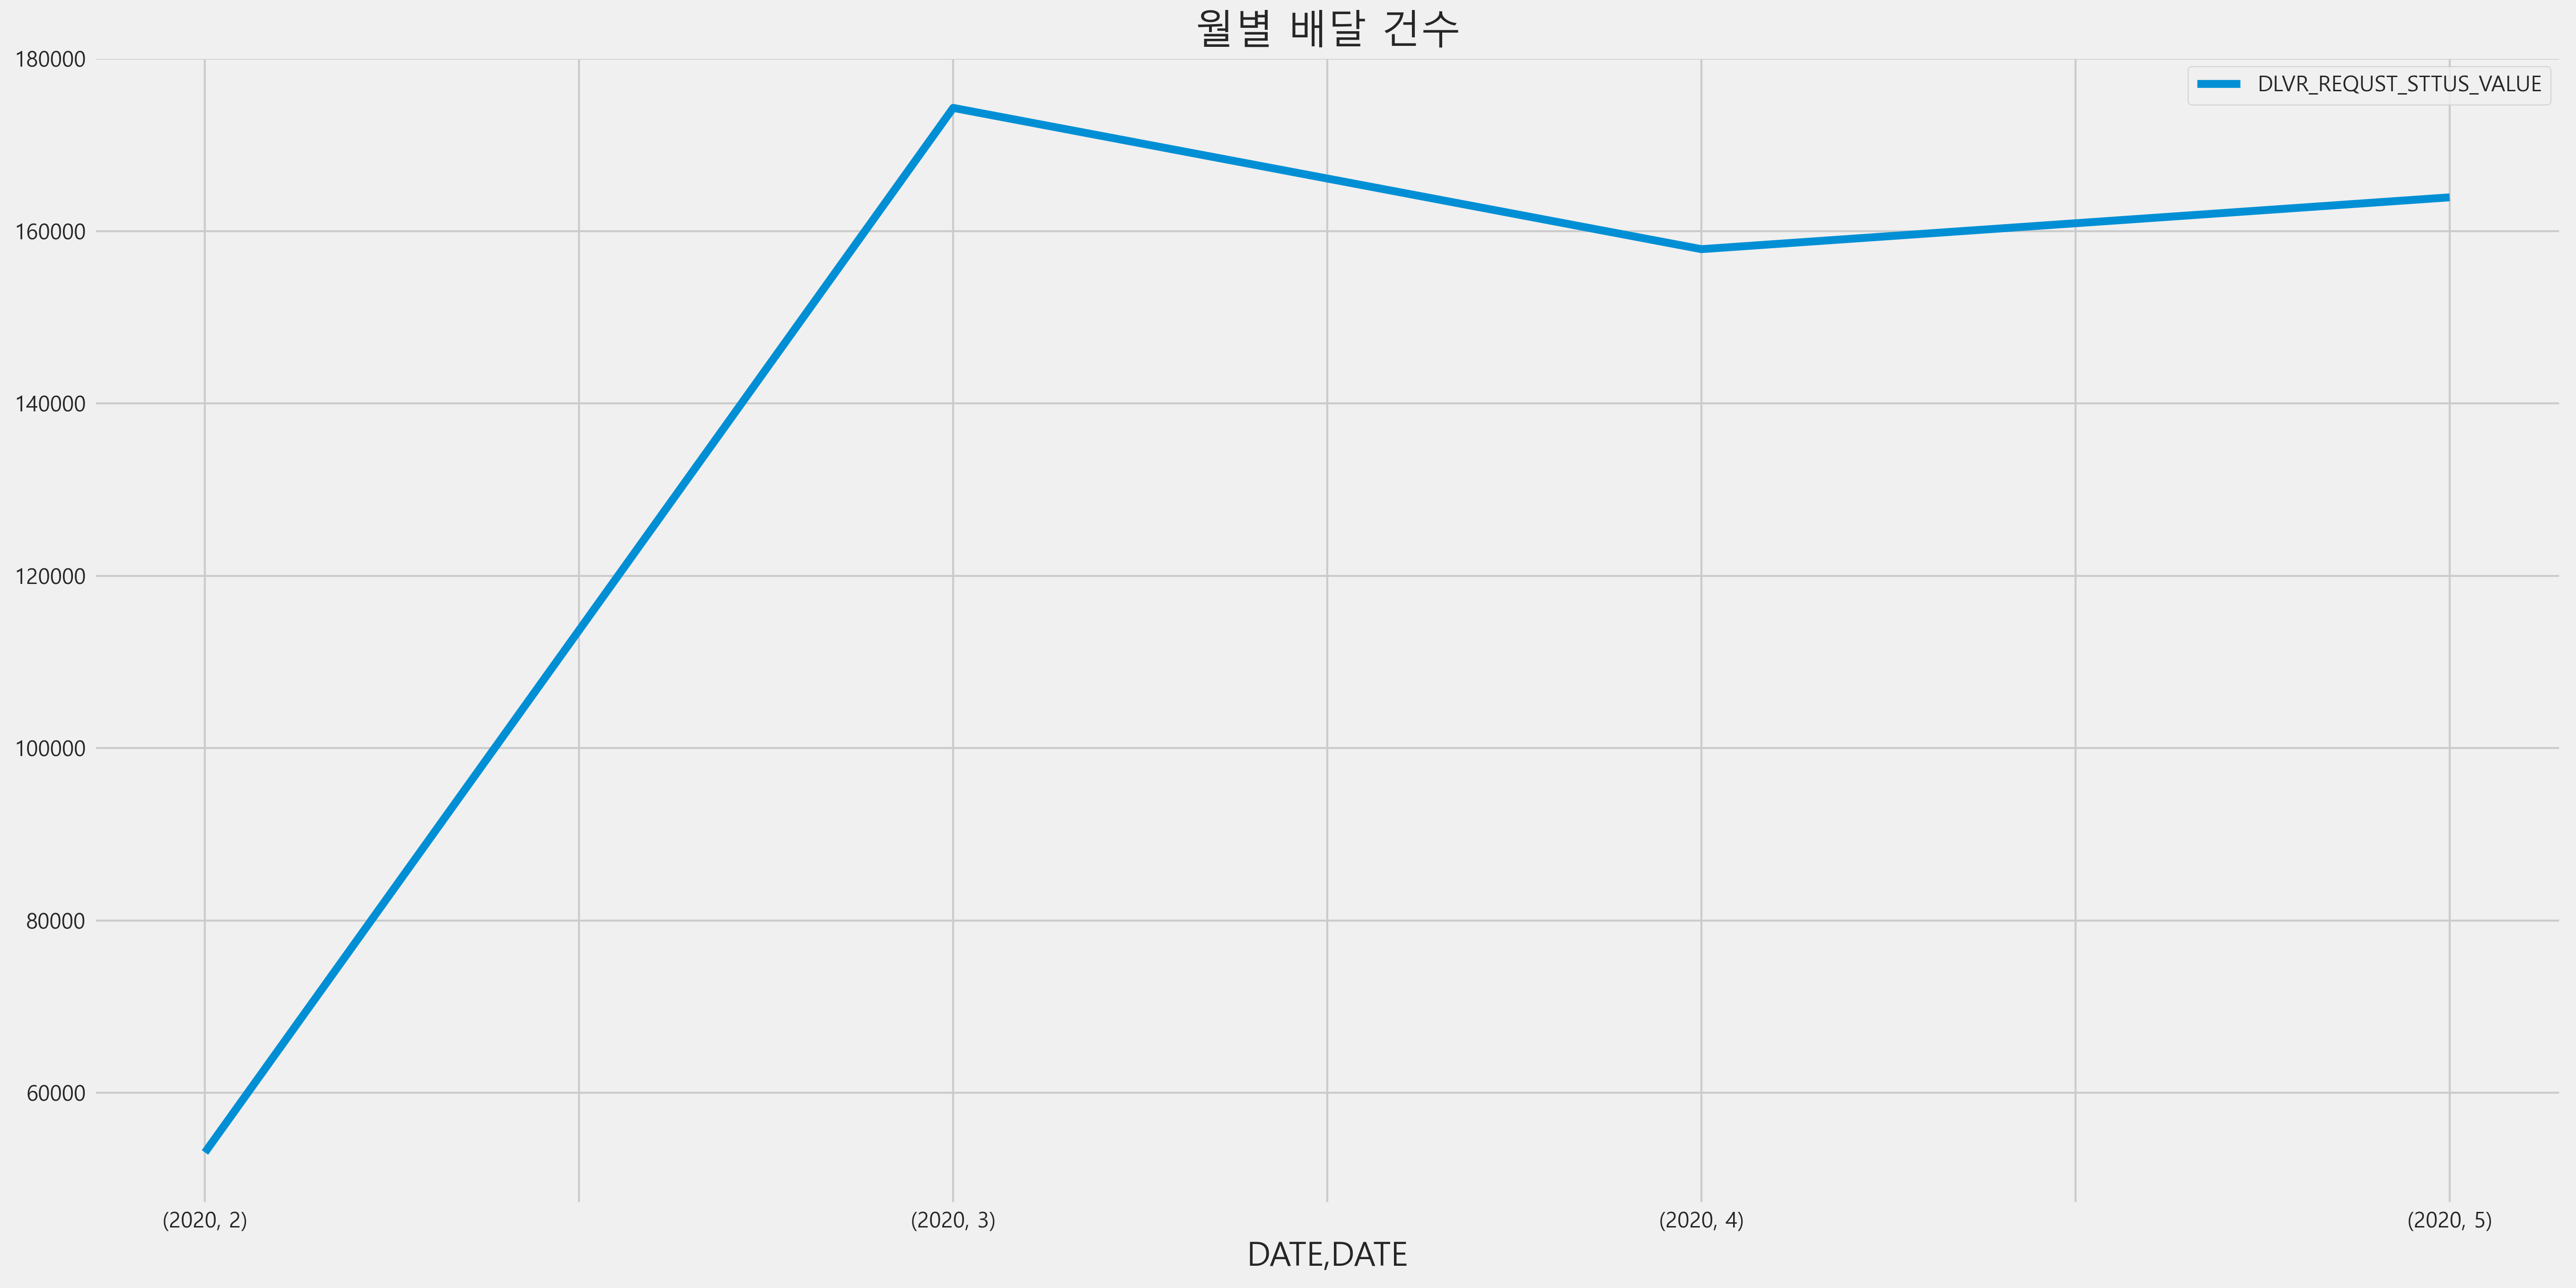

In [23]:
# 월별 주문 건수
dlvr_groupby.plot(use_index = True, y = ["DLVR_REQUST_STTUS_VALUE"], figsize = (20, 10), title = "월별 배달 건수")

<AxesSubplot:title={'center':'일별 배달 건수'}, xlabel='PROCESS_DT'>

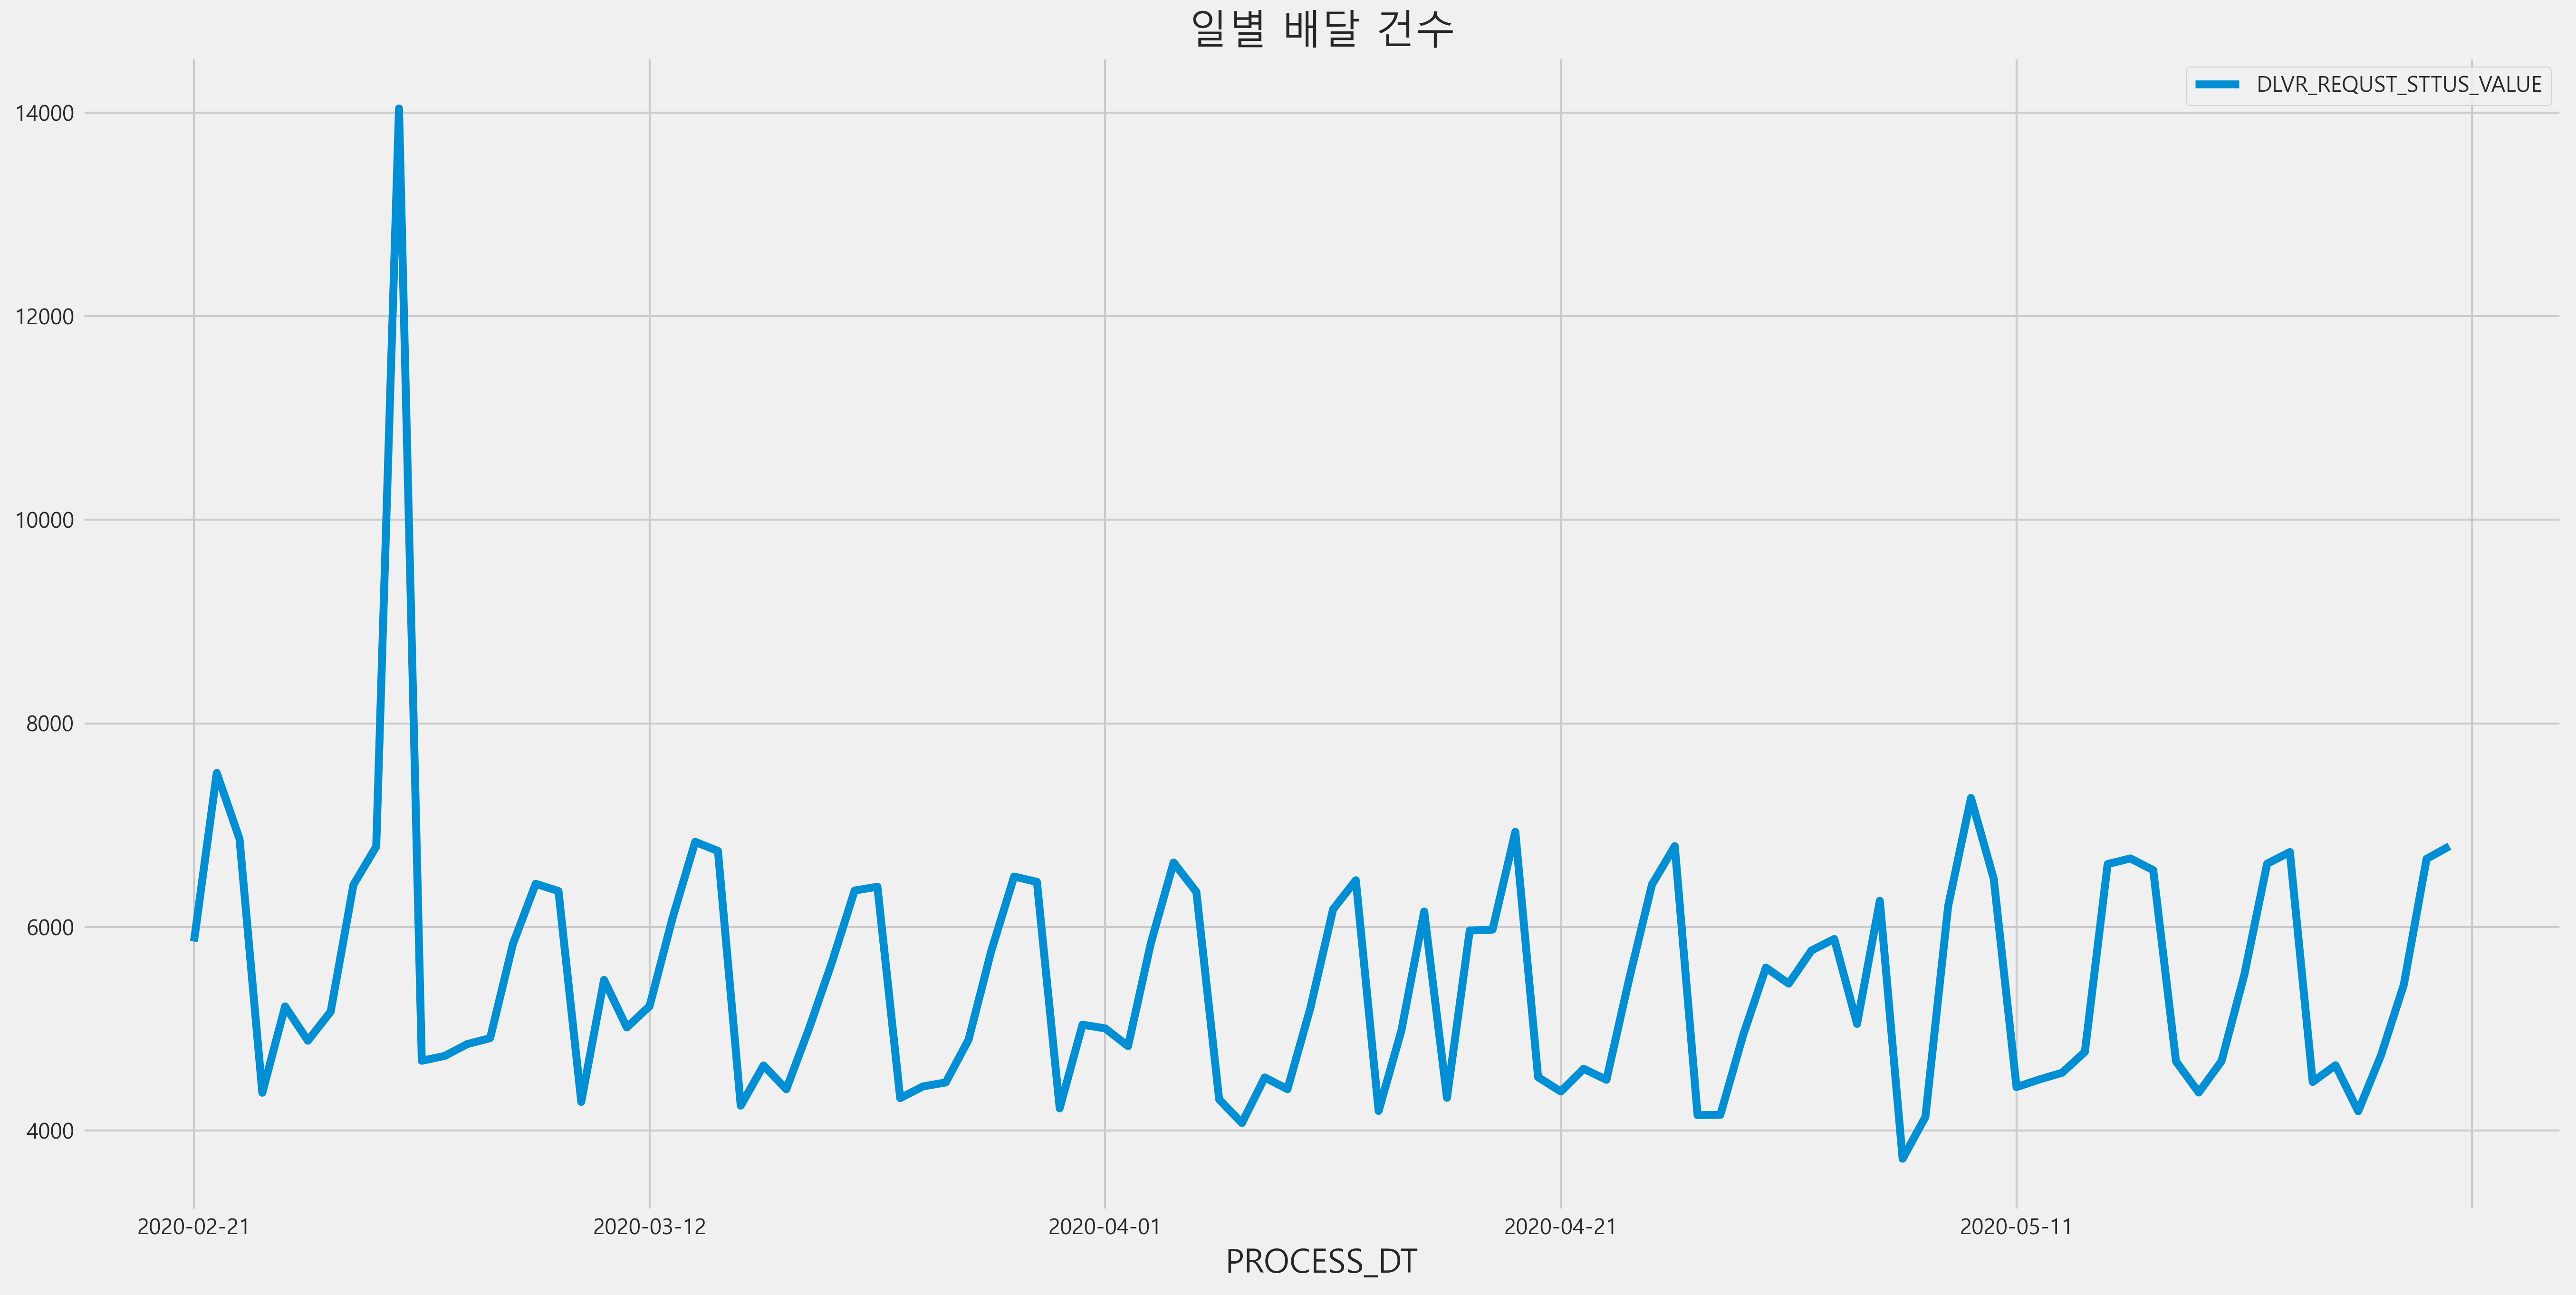

In [24]:
# 일별 배달 건수
dlvr_completed.groupby(["PROCESS_DT"]).count().plot(use_index = True, y = ["DLVR_REQUST_STTUS_VALUE"], figsize = (20, 10), title = "일별 배달 건수")

### 전체 평균 배달 건수

In [39]:
# 전체 평균 배달 건수
total_avg_count=dlvr_completed.groupby(["PROCESS_DT"])[['DLVR_REQUST_STTUS_VALUE']].count()
total_avg_count=total_avg_count.mean()
print("전체 평균 배달 건수 : ",total_avg_count.values)

전체 평균 배달 건수 :  [5492.23]


In [12]:
# 코로나 환자 Data Read
covid_patient = pd.DataFrame(pd.read_csv("covid_19_dataset/PatientInfo.csv", encoding = "utf8"))

In [13]:
# 분석 시작일과 종료일 사이의 확진 건수 select
covid_patient = covid_patient[covid_patient["confirmed_date"] >= first_epidemic]
covid_patient = covid_patient[covid_patient["confirmed_date"] <= end_date]

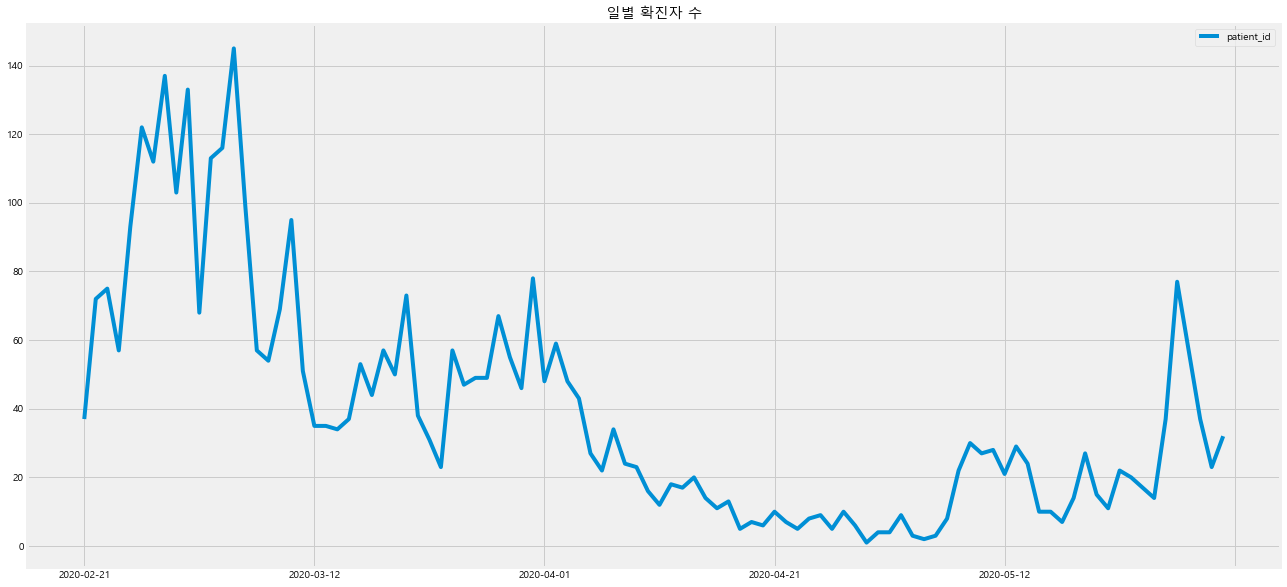

In [14]:
# 서울 지역의 일일 확진자 수 plot
ax = covid_patient.groupby(["confirmed_date"]).count().plot(use_index = True, y = "patient_id", figsize = (20, 10), title = "일별 확진자 수")
hide_x_label(ax)

In [15]:
covid_patient['DATE']=pd.to_datetime(covid_patient['confirmed_date'],format="%Y-%m-%d")
covid_patient.set_index('DATE',inplace=True)

# 확진자 데이터를 년, 월을 기준으로 묶고, 각 년, 월에 발생한 확진자 수를 sum
covid_groupby = covid_patient.groupby(by=[covid_patient.index.year, covid_patient.index.month]).count()

<AxesSubplot:xlabel='DATE,DATE'>

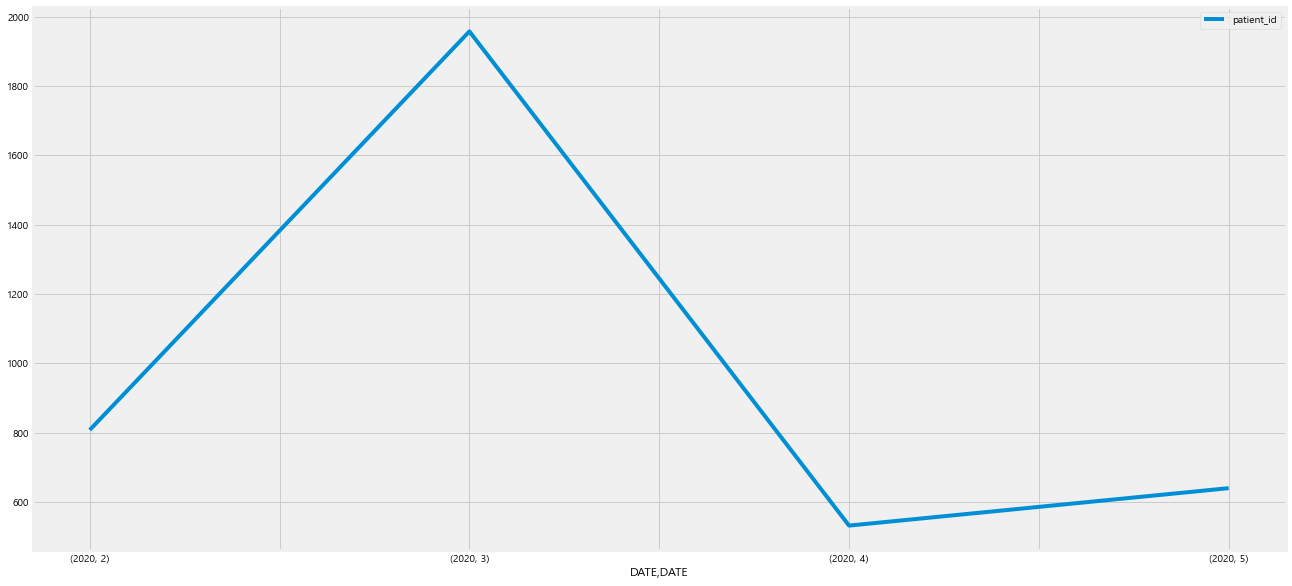

In [16]:
# 서울 지역의 월별 확진자 수

covid_groupby.plot(use_index = True, y = "patient_id", figsize = (20, 10))

코로나 확진자 수와 서울 시 배달 건수의 상관관계를 알아보기 전 서울시의 2020년도 상반기 배달 건수에 대한 현황을 표현해 보았습니다.

배달건수가 높아질 때를 확인해본 결과 코로나가 초기에 가장 많이 발생했던 신천지 교회 코로나 확진자 발생 이후에 배달이 높아진 것을 볼 수 있었고, 이태원 클럽, 쿠팡 물류센터 확진자 발생 이후 배달량이 증가하는 것을 확인할 수 있었습니다.

배달건수와 코로나 확진자 수의 상관관계를 파악하기 위하여 2020년 2월 21일부터 2020년 5월 31일까지의 데이터를 추출하였습니다.

### 1-2. 업종 별 배달 건수 현황

Text(0.5, 1.0, '코로나 전/후 업종별 배달 건수 비교')

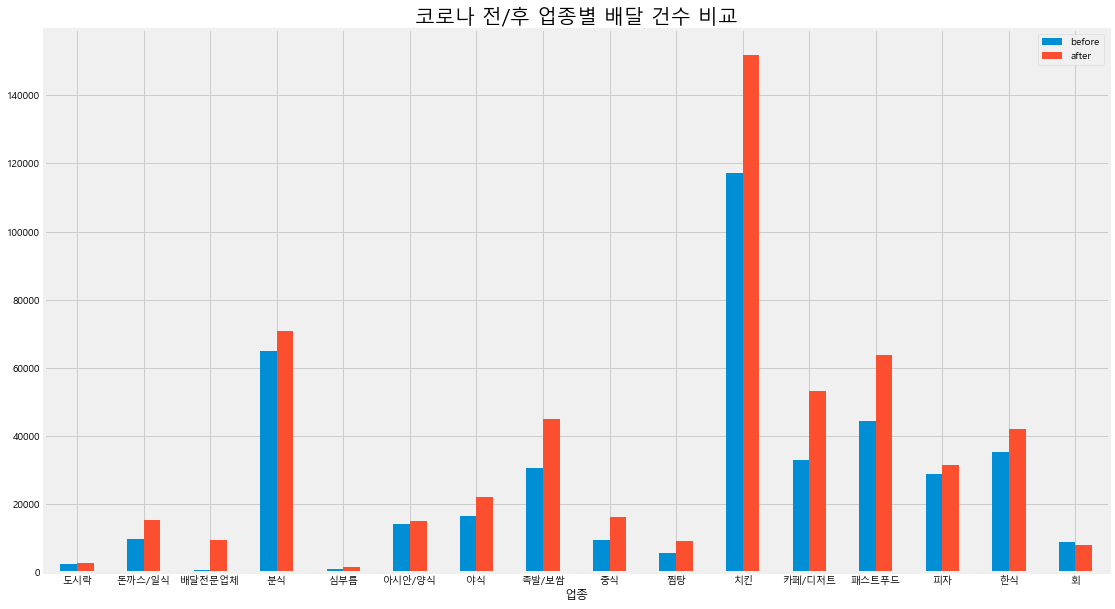

In [17]:
dlvr_call['PROCESS_DT'] = pd.to_datetime(dlvr_call['PROCESS_DT'])
#코로나 전/후
before = dlvr_call[dlvr_call['PROCESS_DT'] < pd.to_datetime(first_epidemic)]
after = dlvr_call[dlvr_call['PROCESS_DT'] >= pd.to_datetime(first_epidemic)]

#코로나 전 후 업종별 배달 건수
before_induty_count=pd.DataFrame(before.groupby(['DLVR_STORE_INDUTY_NM'])['GOODS_AMOUNT'].count()).reset_index()
after_induty_count=pd.DataFrame(after.groupby(['DLVR_STORE_INDUTY_NM'])['GOODS_AMOUNT'].count()).reset_index()
before_induty_count.columns=['업종','before']
after_induty_count.columns=['업종','after']

total=before_induty_count.join(after_induty_count.set_index('업종'), on= '업종')
#시각화
total.plot(kind='bar',x='업종',rot=0,figsize=(17,10))
plt.title("코로나 전/후 업종별 배달 건수 비교",fontsize=20)

In [18]:
total

,업종,before,after
0,도시락,2552,2696
1,돈까스/일식,9815,15394
2,배달전문업체,720,9498
3,분식,65054,70679
4,심부름,1013,1512
5,아시안/양식,14214,14984
6,야식,16589,21981
7,족발/보쌈,30669,44849
8,중식,9420,16323
9,찜탕,5796,9237


코로나 발생 전과 후를 비교하여 업종별 배달 건수를 비교하였습니다. 
2019년과 2020년을 비교하려고 하였지만 2019년 데이터가 12월 데이터만 있어 2019년과 2020년을 비교하기에 너무 극단적인 비교값이 나왔기 때문에 2020년 2월 21일 기준인 신천지교회 확진자 발생일을 기준으로 비교를 하였습니다.

코로나 전과 후를 비교하였을 때, 급격하게 증가한 것으로 보이는 분야는 카페/디저트류, 족발/보쌈, 돈까스/일식, 그리고 배달전문업체가 있었습니다. 

* <b>배달전문업체는 코로나 발생 이후 약 13배의 배달 증가량을 보여주는 것으로 확인 되었습니다.</b>

배달전문업체의 배달량 증가로 인하여 배달전문업체의 창업량도 같이 증가하였는지 분석해보았습니다.

### 1-4. 폐기물 발생량 현황

#### 1-4-1. 생활폐기물 발생량 현황

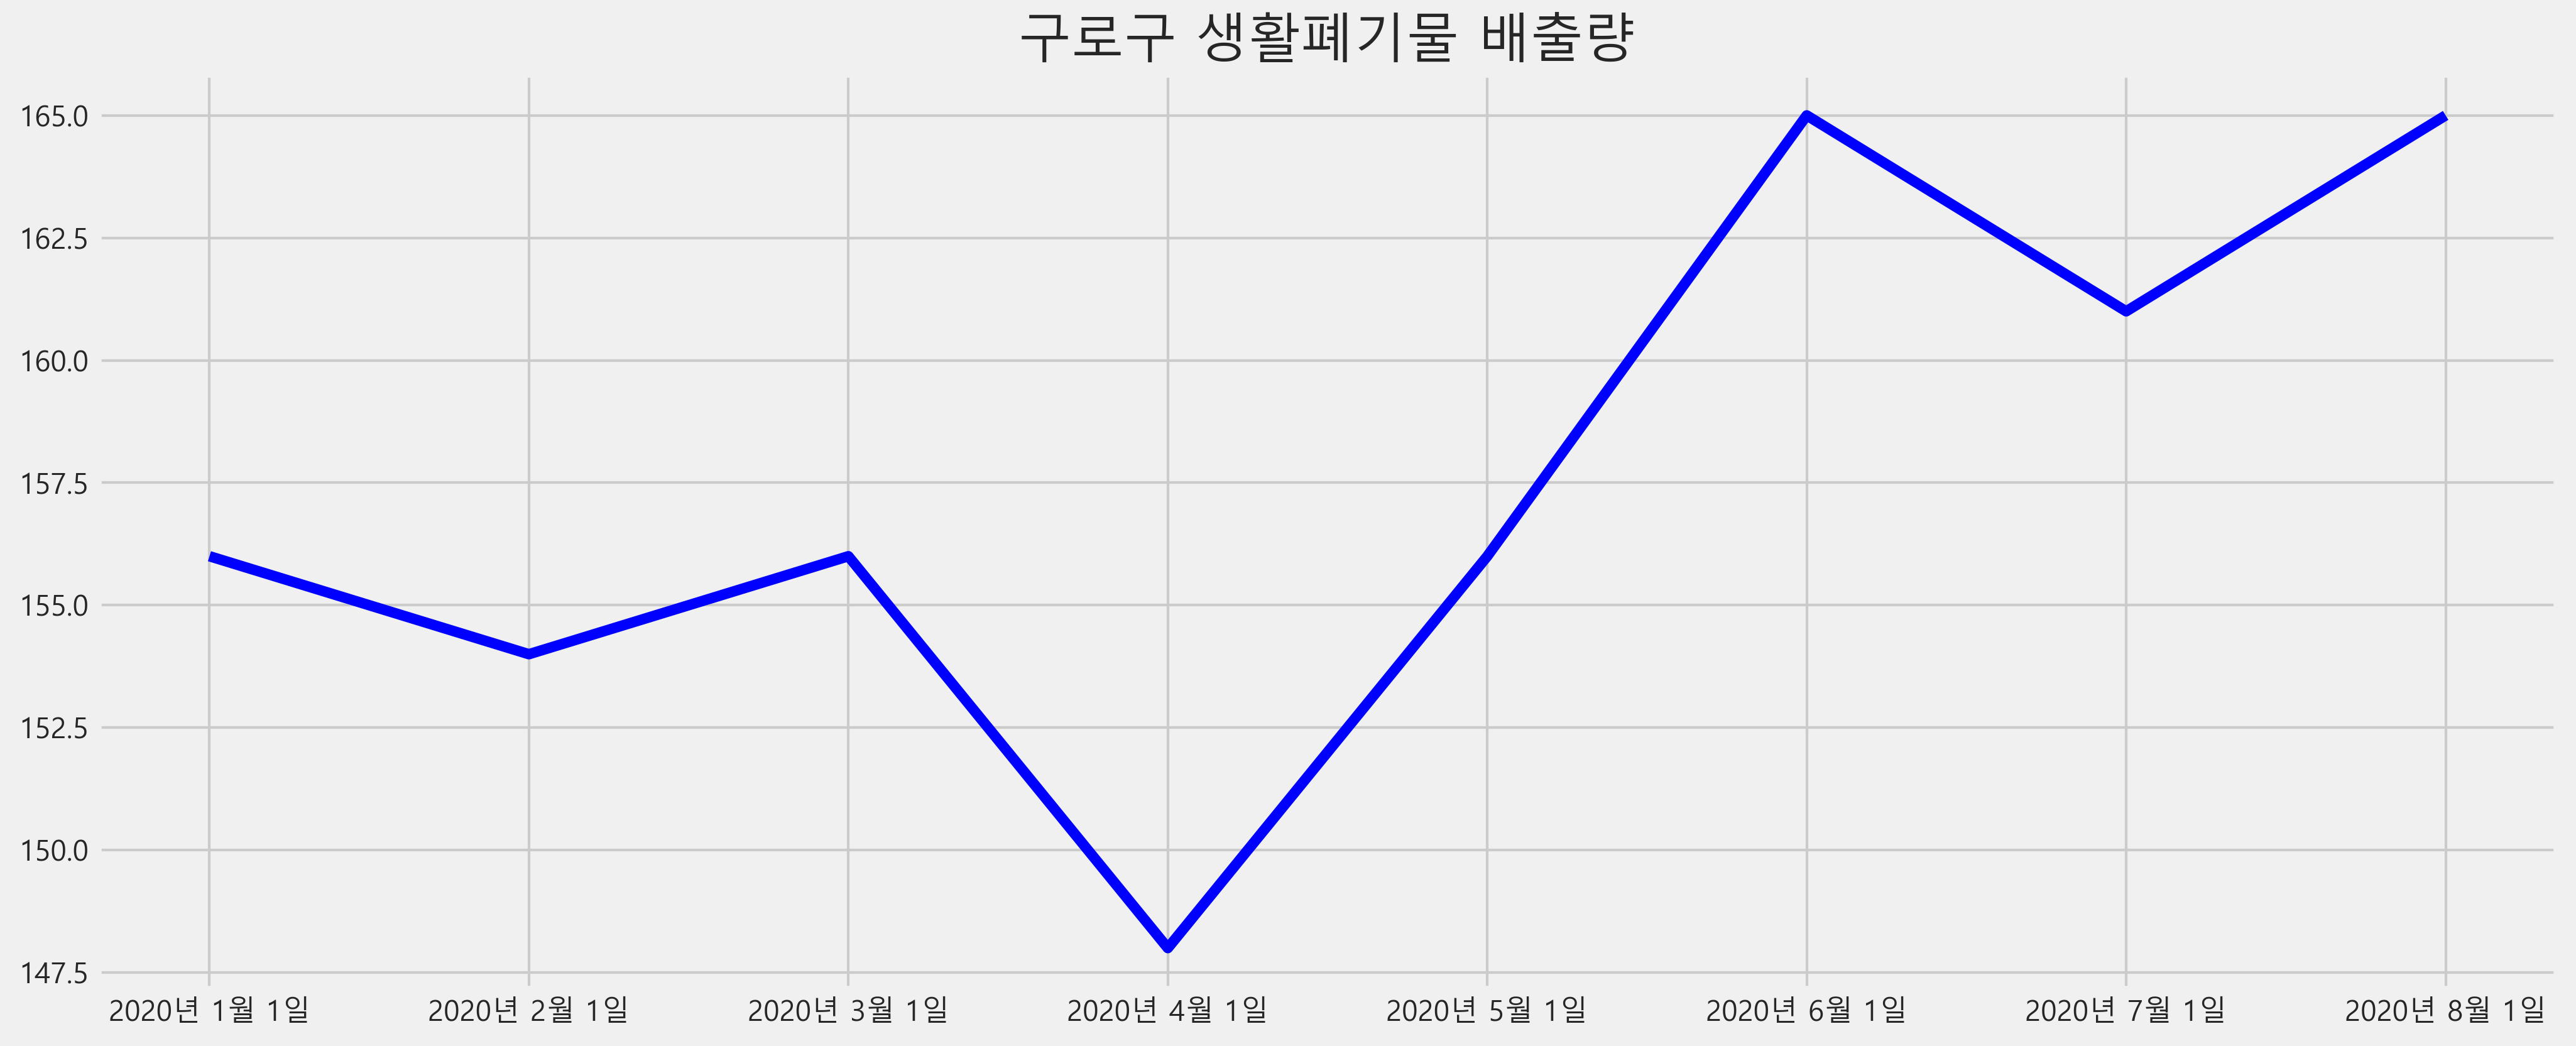

In [12]:
recycle=pd.read_csv("./KT_BigDataPlatform_dataset/2020_guro_recycle_data.csv",encoding="euc-KR")
plt.figure(figsize=(15,6))
plt.plot(recycle['Process Dt'],recycle['생활폐기물'],color='blue')
#plt.text(recycle['Process Dt'],recycle['생활폐기물'],recycle['생활폐기물'])
plt.title("구로구 생활폐기물 배출량")
plt.show()

배달량과 생활폐기물의 상관관계를 분석하기 위하여 서울시의 각 구별 생활폐기물 발생량을 조사하여 시각화하였습니다.

#### 1-4-2. 재활용폐기물 발생량 현황

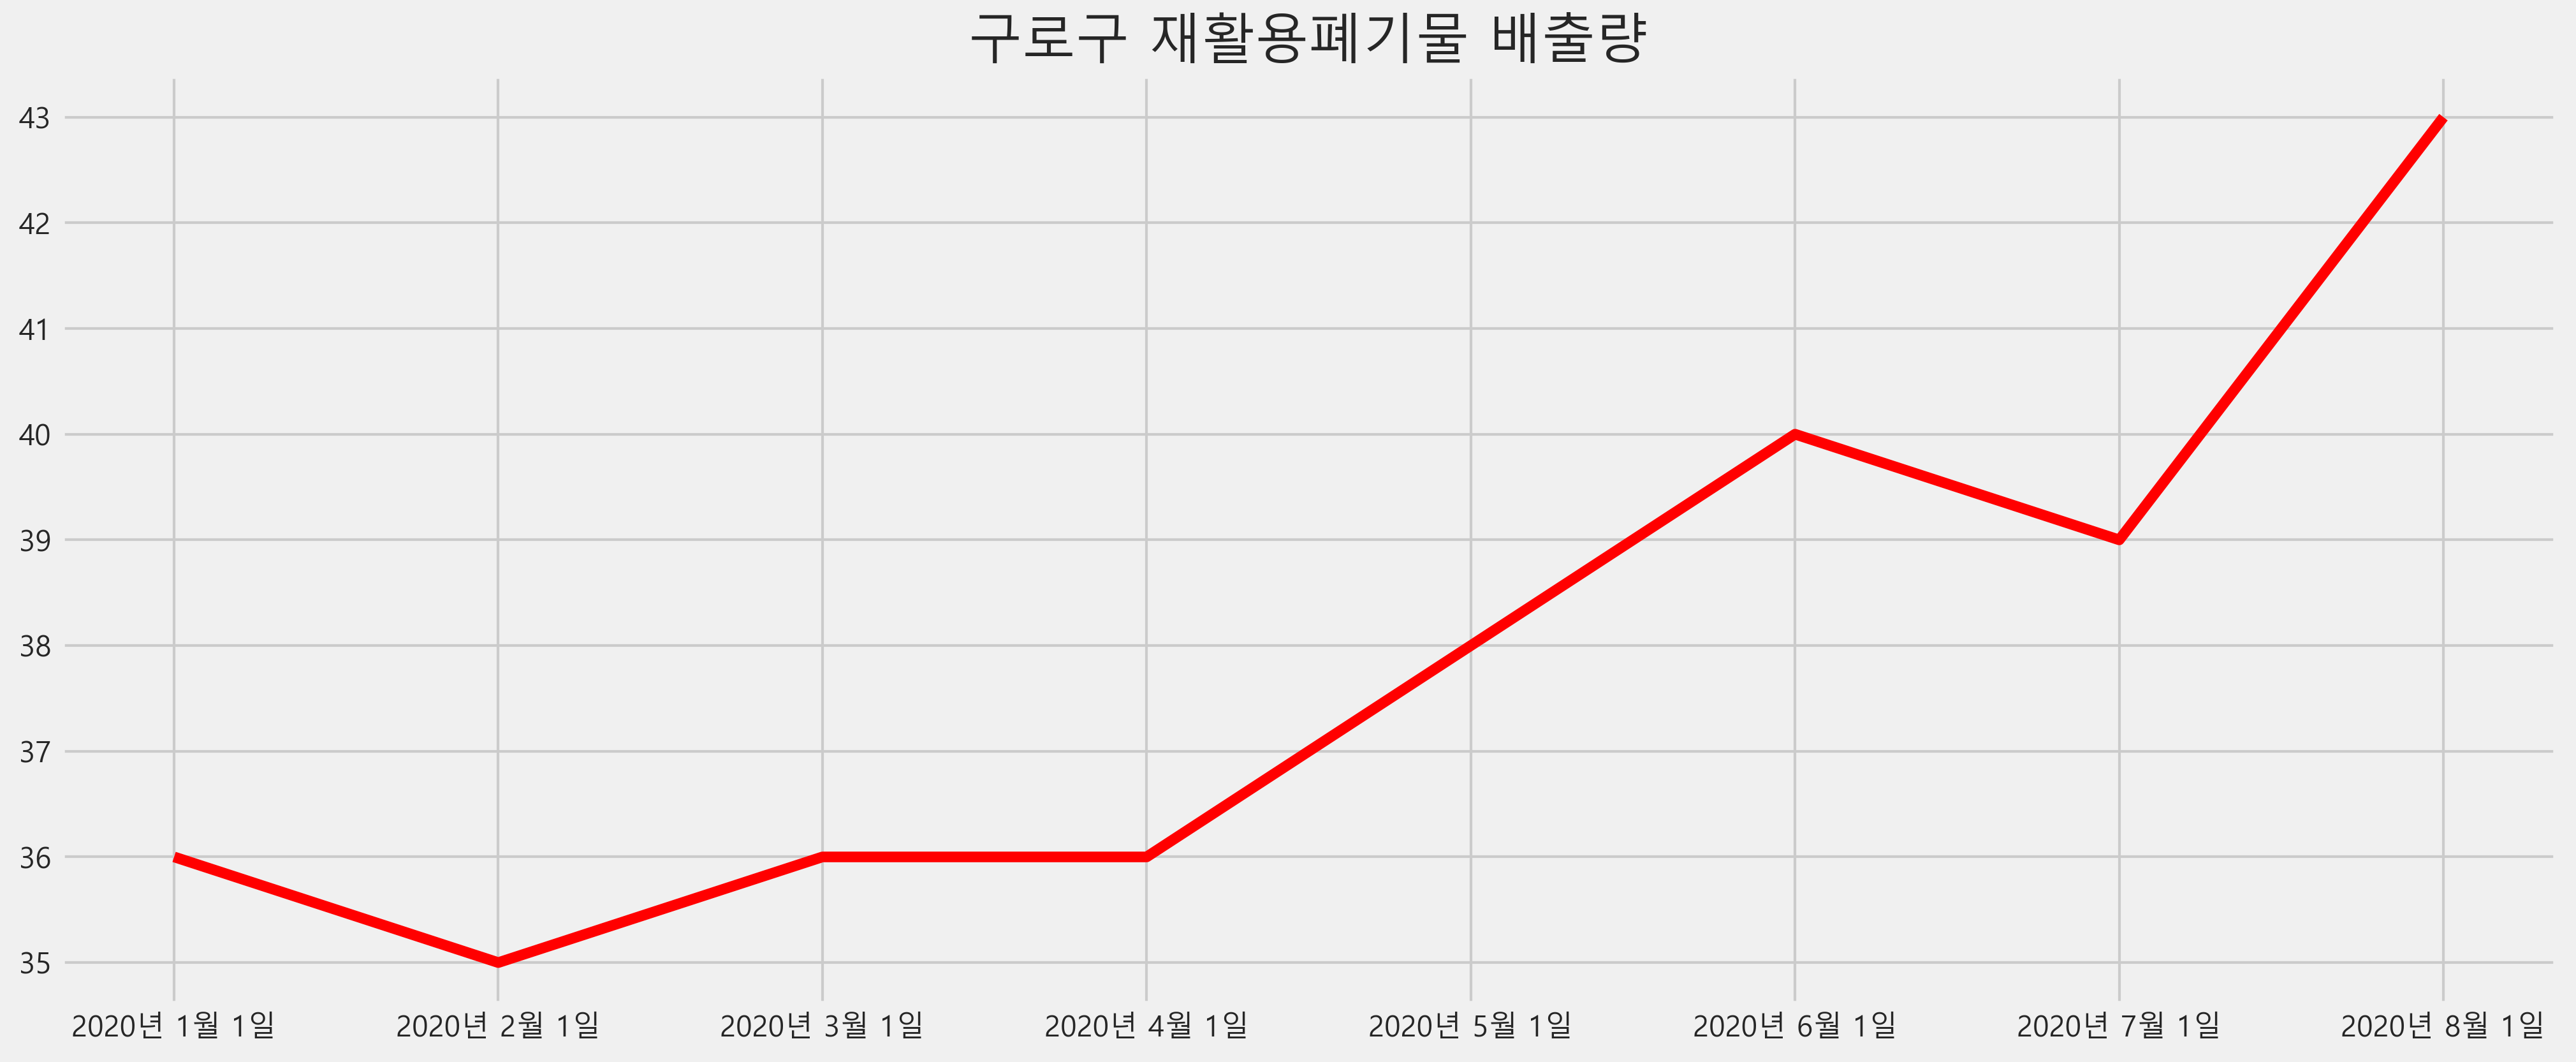

In [13]:
plt.figure(figsize=(15,6))
plt.plot(recycle['Process Dt'],recycle['재활용폐기물'],color='red')
plt.title("구로구 재활용폐기물 배출량")
plt.show()

배달량과 생활폐기물의 상관관계를 분석하기 위하여 서울시의 각 구별 재활용폐기물 발생량을 조사하여 시각화하였습니다.
재활용폐기물의 경우 배달량이 꾸준히 증가함에 따라 비례관계로 같이 증가하는 모습을 확인할 수 있었습니다.

### 2. 코로나-19로 인한 수도권 배달량과 생활폐기물 및 재활용 폐기물 발생량의 상관관계

* 상관관계 분석

#### 2-1. 코로나 확진자 수와 수도권 배달량의 상관관계 분석

(0.7842484776793984, 0.21575152232060157)

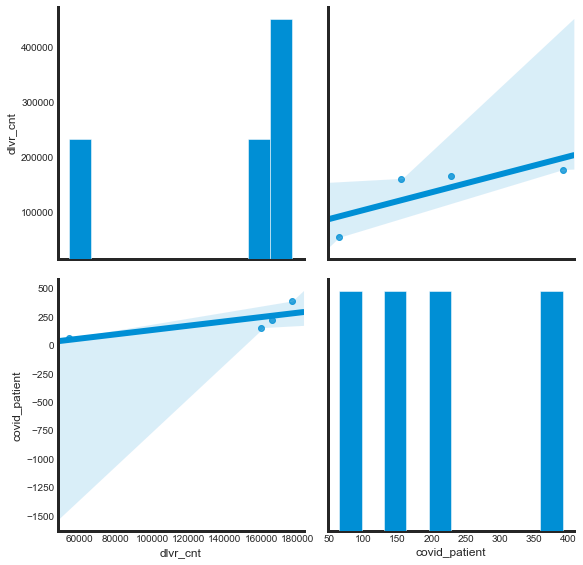

In [29]:
# 분석 시작일과 종료일 사이의 배달 건수, 확진자 정보 select
dlvr_call = dlvr_call[dlvr_call["PROCESS_DT"] >= first_epidemic]
dlvr_call = dlvr_call[dlvr_call["PROCESS_DT"] <= end_date]
corona = corona[corona["confirmed_date"] >= first_epidemic]
corona = corona[corona["confirmed_date"] <= end_date]



dlvr_call_cnt = pd.DataFrame(dlvr_call.groupby('PROCESS_DT')[['GOODS_AMOUNT']].count().to_records())
dlvr_call_cnt['PROCESS_DT']=pd.to_datetime(dlvr_call_cnt['PROCESS_DT'])
dlvr_call_cnt['month_year'] = dlvr_call_cnt['PROCESS_DT'].dt.to_period('M')

dlvr_call_1M_cnt = pd.DataFrame(dlvr_call_cnt.groupby('month_year')[['GOODS_AMOUNT']].sum().to_records())

corona_cnt = pd.DataFrame(corona.groupby('confirmed_date')[['country']].count().to_records())

corona_cnt['confirmed_date']=pd.to_datetime(corona_cnt['confirmed_date'])
corona_cnt['month_year'] = corona_cnt['confirmed_date'].dt.to_period('M')

corona_1M_cnt = pd.DataFrame(corona_cnt.groupby('month_year')[['country']].sum().to_records())

#상관관계분석
correlation=dlvr_call_1M_cnt.join(corona_1M_cnt.set_index('month_year'), on= 'month_year')
correlation.columns=['Date','dlvr_cnt','covid_patient']

#그래프 시각화
sns.pairplot(correlation, kind='reg', height=4) 


# 피어슨 상관계수 검정
corr = stats.pearsonr(correlation.dlvr_cnt, correlation.covid_patient)
corr

2020년 상반기 코로나 확진자 수와 배달량을 상관분석해보았습니다.

상관계수가 0.78로 상관관계가 높게 나왔으며 양의 상관관계를 보여주고 있습니다. 그렇기 때문에 확진자 수가 늘어남으로써 배달량도 증가하는 것은 상관관계가 있기 때문에 코로나로 인한 배달량 증가라는 가설은 증명되었습니다.

이번에는 배달량과 생활폐기물의 상관관계를 분석해보았습니다.

#### 2-2. 수도권 배달량과 생활폐기물 발생량의 상관관계 분석

In [ ]:
dlvr_call_cnt = pd.DataFrame(dlvr_call.groupby('PROCESS_DT')[['GOODS_AMOUNT']].count().to_records())
dlvr_call_cnt['month_year'] = dlvr_call_cnt['PROCESS_DT'].dt.to_period('M')

dlvr_call_1M_cnt = pd.DataFrame(dlvr_call_cnt.groupby('month_year')[['GOODS_AMOUNT']].sum().to_records())

recycle['Process Dt']=pd.to_datetime(recycle['Process Dt'])
recycle['month_year'] = recycle['Process Dt'].dt.to_period('M')
recycle=recycle[:6]
recycle=recycle[['month_year','재활용폐기물']]

#상관관계분석
correlation=dlvr_call_1M_cnt.join(recycle.set_index('month_year'), on= 'month_year')
correlation.columns=['Date','dlvr_cnt','recycle']

#그래프 시각화
sns.pairplot(correlation, kind='reg', height=4) 


# 피어슨 상관계수 검정
corr = stats.pearsonr(correlation.dlvr_cnt, correlation.recycle)
corr

2020년 상반기 배달건수와 재활용 폐기물 발생량의 상관관계 분석을 해보았습니다.

상관계수가 0.00로 높게 나왔으며 양의 상관관계를 보여주고 있습니다. 배달량이 늘어남으로써 생활 및 재활용폐기물 발생량도 증가하고 있다는 것을 증명하였습니다.


## 결론 및 제안

코로나 확진자가 늘어남에 따라 배달문화가 변하고 있고 배달량 또한 계속해서 늘어나고 있는 상황입니다. 그리고 배달량이 늘어남에 따라 생활 및 재활용 폐기물의 발생량 또한 증가하고 있습니다. 

<b>코로나로 인하여 배달문화가 변화되고 있고 배달이 일상화가 되고 있는 시점에서 환경에 대하여 다시 한번 생각할 필요가 있다고 생각합니다. </b>

현재 대한민국이 전세계에서 배달을 가장 많이 하는 나라라고 합니다. 선진국으로서 한국이 솔선수범하여 환경을 생각하는 일회용 수저 안받기 챌린지나 다회용기 사용을 추구하여 실천한다면 일회용폐기물의 발생량을 일 평균 5000개 정도 절약할 수 있습니다.
